##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 函数式 API

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/keras/functional" class=""><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/functional.ipynb" class=""><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/functional.ipynb" class=""><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/functional.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

## 设置

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 简介

Keras *函数式 API* 是一种比 `tf.keras.Sequential` API 更加灵活的模型创建方式。函数式 API 可以处理具有非线性拓扑的模型、具有共享层的模型，以及具有多个输入或输出的模型。

深度学习模型通常是层的有向无环图 (DAG)。因此，函数式 API 是构建*层计算图*的一种方式。

请考虑以下模型：

```
(input: 784-dimensional vectors)        ↧ [Dense (64 units, relu activation)]        ↧ [Dense (64 units, relu activation)]        ↧ [Dense (10 units, softmax activation)]        ↧ (output: logits of a probability distribution over 10 classes)
```

这是一个具有三层的基本计算图。要使用函数式 API 构建此模型，请先创建一个输入节点：

In [3]:
inputs = keras.Input(shape=(784,))

数据的形状设置为 784 维向量。由于仅指定了每个样本的形状，因此始终忽略批次大小。

例如，如果您有一个形状为 `(32, 32, 3)` 的图像输入，则可以使用：

In [4]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

返回的 `inputs` 包含馈送给模型的输入数据的形状和 `dtype`。形状如下：

In [5]:
inputs.shape

TensorShape([None, 784])

dtype 如下：

In [6]:
inputs.dtype

tf.float32

可以通过在此 `inputs` 对象上调用层，在层计算图中创建新的节点：

In [7]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

“层调用”操作就像从“输入”向您创建的该层绘制一个箭头。您将输入“传递”到 `dense` 层，然后得到 `x`。

让我们为层计算图多添加几个层：

In [8]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

此时，您可以通过在层计算图中指定模型的输入和输出来创建 `Model`：

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

让我们看看模型摘要是什么样子：

In [10]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


您还可以将模型绘制为计算图：

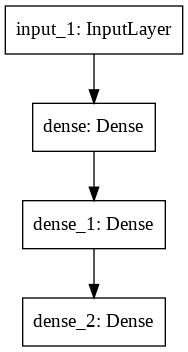

In [11]:
keras.utils.plot_model(model, "my_first_model.png")

并且，您还可以选择在绘制的计算图中显示每层的输入和输出形状：

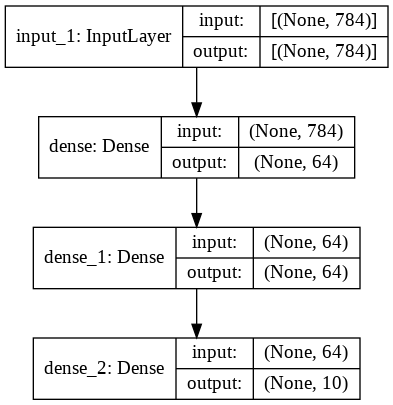

In [12]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

此图和代码几乎完全相同。在代码版本中，连接箭头由调用操作代替。

“层计算图”是深度学习模型的直观心理图像，而函数式 API 是创建密切反映此图像的模型的方法。

## 训练、评估和推断

对于使用函数式 API 构建的模型来说，其训练、评估和推断的工作方式与 `Sequential` 模型完全相同。

如下所示，加载 MNIST 图像数据，将其改造为向量，将模型与数据拟合（同时监视验证拆分的性能），然后在测试数据上评估模型：

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 2s 2ms/step - loss: 0.3407 - accuracy: 0.9031 - val_loss: 0.1911 - val_accuracy: 0.9458
Epoch 2/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1627 - accuracy: 0.9514 - val_loss: 0.1451 - val_accuracy: 0.9589
313/313 - 0s - loss: 0.1406 - accuracy: 0.9584
Test loss: 0.14063824713230133
Test accuracy: 0.9584000110626221


有关更多信息，请参阅[训练和评估](https://tensorflow.google.cn/guide/keras/train_and_evaluate/)指南。

## 保存和序列化

对于使用函数式 API 构建的模型，其保存模型和序列化的工作方式与 `Sequential` 模型相同。保存函数式模型的标准方式是调用 `model.save()` 将整个模型保存为单个文件。您可以稍后从该文件重新创建相同的模型，即使构建该模型的代码已不再可用。

保存的文件包括：

- 模型架构
- 模型权重值（在训练过程中得知）
- 模型训练配置（如果有的话，如传递给 `compile`）
- 优化器及其状态（如果有的话，用来从上次中断的地方重新开始训练）

In [14]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


有关详细信息，请阅读模型[序列化和保存](https://tensorflow.google.cn/guide/keras/save_and_serialize/)指南。

## 使用相同的层计算图定义多个模型

在函数式 API 中，模型是通过在层计算图中指定其输入和输出来创建的。这意味着可以使用单个层计算图来生成多个模型。

在下面的示例中，您将使用相同的层堆栈来实例化两个模型：能够将图像输入转换为 16 维向量的 `encoder` 模型，以及用于训练的端到端 `autoencoder` 模型。

In [15]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

在上例中，解码架构与编码架构严格对称，因此输出形状与输入形状 `(28, 28, 1)` 相同。

`Conv2D` 层的反面是 `Conv2DTranspose` 层，`MaxPooling2D` 层的反面是 `UpSampling2D` 层。

## 所有模型均可像层一样调用

您可以通过在 `Input` 上或在另一个层的输出上调用任何模型来将其当作层来处理。通过调用模型，您不仅可以重用模型的架构，还可以重用它的权重。

为了查看实际运行情况，下面是对自动编码器示例的另一种处理方式，该示例创建了一个编码器模型、一个解码器模型，并在两个调用中将它们链接，以获得自动编码器模型：

In [16]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

如您所见，模型可以嵌套：模型可以包含子模型（因为模型就像层一样）。模型嵌套的一个常见用例是*装配*。例如，以下展示了如何将一组模型装配成一个平均其预测的模型：

In [17]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

## 处理复杂的计算图拓扑

### 具有多个输入和输出的模型

函数式 API 使处理多个输入和输出变得容易。而这无法使用 `Sequential` API 处理。

例如，如果您要构建一个系统，该系统按照优先级对自定义问题工单进行排序，然后将工单传送到正确的部门，则此模型将具有三个输入：

- 工单标题（文本输入），
- 工单的文本正文（文本输入），以及
- 用户添加的任何标签（分类输入）

此模型将具有两个输出：

- 介于 0 和 1 之间的优先级分数（标量 Sigmoid 输出），以及
- 应该处理工单的部门（部门范围内的 Softmax 输出）。

您可以使用函数式 API 通过几行代码构建此模型：

In [18]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

现在绘制模型：

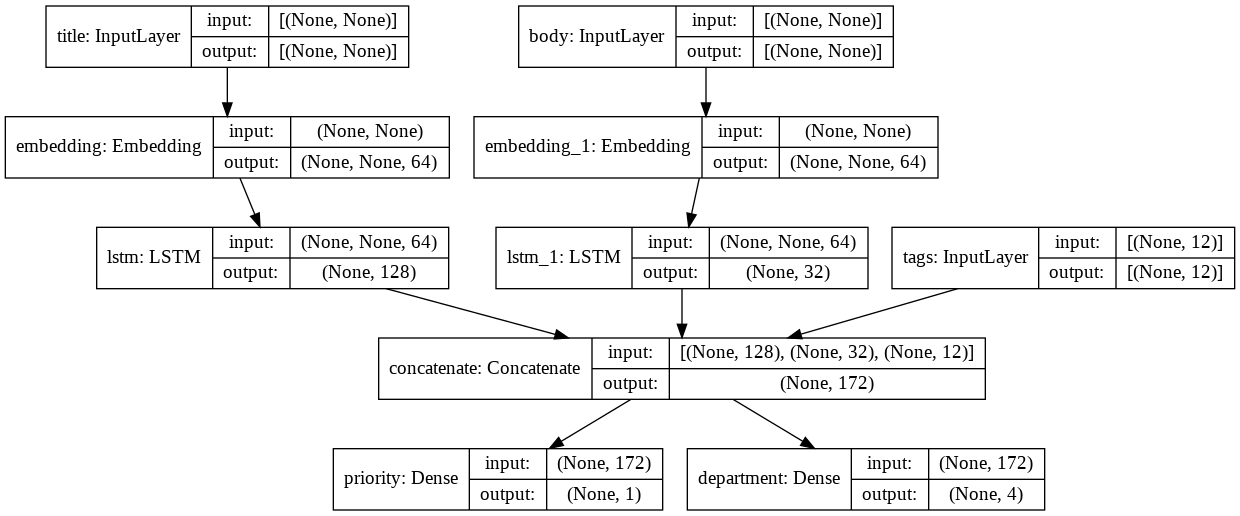

In [19]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

编译此模型时，可以为每个输出分配不同的损失。甚至可以为每个损失分配不同的权重，以调整其对总训练损失的贡献。

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

由于输出层具有不同的名称，您还可以像下面这样指定损失：

In [21]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

通过传递输入和目标的 NumPy 数组列表来训练模型：

In [22]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 5s 44ms/step - loss: 1.2886 - priority_loss: 0.7048 - department_loss: 2.9192
Epoch 2/2
40/40 [==============================] - 2s 43ms/step - loss: 1.2855 - priority_loss: 0.6987 - department_loss: 2.9339


当使用 `Dataset` 对象调用拟合时，它应该会生成一个列表元组（如 `([title_data, body_data, tags_data], [priority_targets, dept_targets])` 或一个字典元组（如 `({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`）。

有关详细说明，请参阅[训练和评估](https://tensorflow.google.cn/guide/keras/train_and_evaluate/)指南。

### 小 ResNet 模型

除了具有多个输入和输出的模型外，函数式 API 还使处理非线性连接拓扑（这些模型的层没有按顺序连接）变得容易。这是 `Sequential` API 无法处理的。

关于这一点的一个常见用例是残差连接。让我们来为 CIFAR10 构建一个小 ResNet 模型以进行演示：

In [23]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_________________________________________________________________________________________

绘制模型：

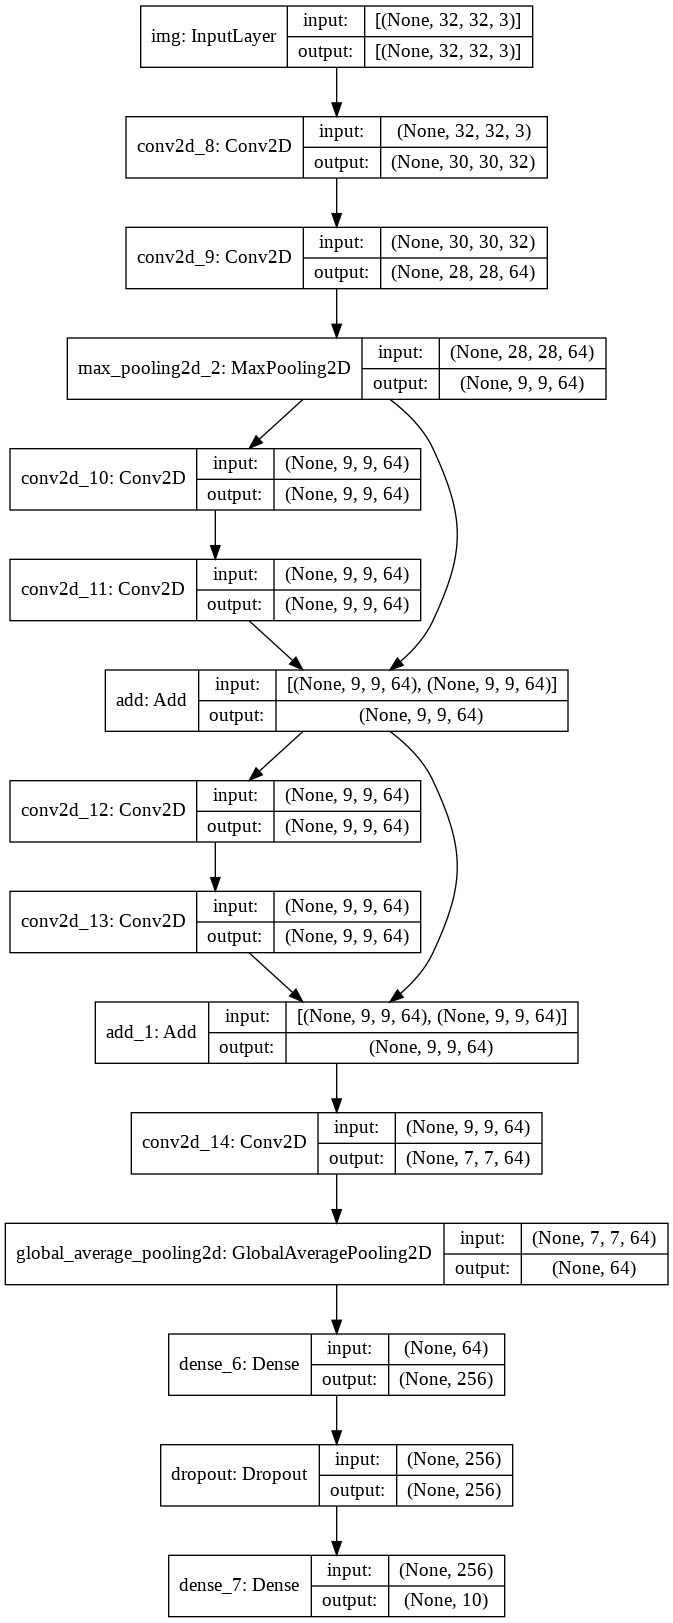

In [24]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

现在训练模型：

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 5s 304ms/step - loss: 2.3372 - acc: 0.0950 - val_loss: 2.2986 - val_acc: 0.1150


## 共享层

函数式 API 的另一个很好的用途是使用*共享层*的模型。共享层是在同一个模型中多次重用的层实例，它们会学习与层计算图中的多个路径相对应的特征。

共享层通常用于对来自相似空间（例如，两个具有相似词汇的不同文本）的输入进行编码。它们可以实现在这些不同的输入之间共享信息，以及在更少的数据上训练这种模型。如果在其中的一个输入中看到了一个给定单词，那么将有利于处理通过共享层的所有输入。

要在函数式 API 中共享层，请多次调用同一个层实例。例如，下面是一个在两个不同文本输入之间共享的 `Embedding` 层：

In [26]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## 提取和重用层计算图中的节点

由于要处理的层计算图是静态数据结构，可以对其进行访问和检查。而这就是将函数式模型绘制为图像的方式。

这也意味着您可以访问中间层的激活函数（计算图中的“节点”）并在其他地方重用它们，这对于特征提取之类的操作十分有用。

让我们来看一个例子。下面是一个 VGG19 模型，其权重已在 ImageNet 上进行了预训练：

In [27]:
vgg19 = tf.keras.applications.VGG19()

574726144/574710816 [==============================] - 5s 0us/step


下面是通过查询计算图数据结构获得的模型的中间激活：

In [28]:
features_list = [layer.output for layer in vgg19.layers]

使用以下特征来创建新的特征提取模型，该模型会返回中间层激活的值：

In [29]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

这尤其适用于诸如[神经样式转换](https://tensorflow.google.cn/tutorials/generative/style_transfer)之类的任务。

## 使用自定义层扩展 API

`tf.keras` 包含了各种内置层，例如：

- 卷积层：`Conv1D`、`Conv2D`、`Conv3D`、`Conv2DTranspose`
- 池化层：`MaxPooling1D`、`MaxPooling2D`、`MaxPooling3D`、`AveragePooling1D`
- RNN 层：`GRU`、`LSTM`、`ConvLSTM2D`
- `BatchNormalization`、`Dropout`、`Embedding` 等

但是，如果找不到所需内容，可以通过创建您自己的层来方便地扩展 API。所有层都会子类化 `Layer` 类并实现下列方法：

- `call` 方法，用于指定由层完成的计算。
- `build` 方法，用于创建层的权重（这只是一种样式约定，因为您也可以在 `__init__` 中创建权重）。

要详细了解从头开始创建层的详细信息，请阅读[自定义层和模型](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)指南。

以下是 `tf.keras.layers.Dense` 的基本实现：

In [30]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

为了在您的自定义层中支持序列化，请定义一个 `get_config` 方法，返回层实例的构造函数参数：

In [31]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

您也可以选择实现 `from_config(cls, config)` 类方法，该方法用于在给定其配置字典的情况下重新创建层实例。`from_config` 的默认实现如下：

```python
def from_config(cls, config):   return cls(**config)
```

## 何时使用函数式 API

什么时候应该使用 Keras 函数式 API 来创建新的模型，或者什么时候应该直接对 `Model` 类进行子类化呢？通常来说，函数式 API 更高级、更易用且更安全，并且具有许多子类化模型所不支持的功能。

但是，当构建不容易表示为有向无环的层计算图的模型时，模型子类化会提供更大的灵活性。例如，您无法使用函数式 API 来实现 Tree-RNN，而必须直接子类化 `Model` 类。

要深入了解函数式 API 和模型子类化之间的区别，请阅读 [TensorFlow 2.0 符号式 API 和命令式 API 介绍](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)。

### 函数式 API 的优势：

下列属性对于序贯模型（也是数据结构）同样适用，但对于子类化模型（是 Python 字节码而非数据结构）则不适用。

#### 更加简洁

没有 `super(MyClass, self).__init__(...)`，没有 `def call(self, ...):` 等内容。

对比：

```python
inputs = keras.Input(shape=(32,)) x = layers.Dense(64, activation='relu')(inputs) outputs = layers.Dense(10)(x) mlp = keras.Model(inputs, outputs)
```

下面是子类化版本：

```python
class MLP(keras.Model):    def __init__(self, **kwargs):     super(MLP, self).__init__(**kwargs)     self.dense_1 = layers.Dense(64, activation='relu')     self.dense_2 = layers.Dense(10)    def call(self, inputs):     x = self.dense_1(inputs)     return self.dense_2(x)  # Instantiate the model. mlp = MLP() # Necessary to create the model's state. # The model doesn't have a state until it's called at least once. _ = mlp(tf.zeros((1, 32)))
```

#### 定义连接计算图时进行模型验证

在函数式 API 中，输入规范（形状和 dtype）是预先创建的（使用 `Input`）。每次调用层时，该层都会检查传递给它的规范是否符合其假设，如不符合，它将引发有用的错误消息。

这样可以保证能够使用函数式 API 构建的任何模型都可以运行。所有调试（除与收敛有关的调试外）均在模型构造的过程中静态发生，而不是在执行时发生。这类似于编译器中的类型检查。

#### 函数式模型可绘制且可检查

您可以将模型绘制为计算图，并且可以轻松访问该计算图中的中间节点。例如，要提取和重用中间层的激活（如前面的示例所示），请运行以下代码：

```python
features_list = [layer.output for layer in vgg19.layers] feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```

#### 函数式模型可以序列化或克隆

因为函数式模型是数据结构而非一段代码，所以它可以安全地序列化，并且可以保存为单个文件，从而使您可以重新创建完全相同的模型，而无需访问任何原始代码。请参阅[序列化和保存](https://tensorflow.google.cn/guide/keras/save_and_serialize/)指南。

要序列化子类化模型，实现器必须在模型级别指定 `get_config()` 和 `from_config()` 方法。

### 函数式 API 的劣势：

#### 不支持动态架构

函数式 API 将模型视为层的 DAG。对于大多数深度学习架构来说确实如此，但并非所有（例如，递归网络或 Tree RNN 就不遵循此假设，无法在函数式 API 中实现）。

## 混搭 API 样式

在函数式 API 或模型子类化之间进行选择并非是让您作出二选一的决定而将您限制在某一类模型中。`tf.keras` API 中的所有模型都可以彼此交互，无论它们是 `Sequential` 模型、函数式模型，还是从头开始编写的子类化模型。

您始终可以将函数式模型或 `Sequential` 模型用作子类化模型或层的一部分：

In [32]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


您可以在函数式 API 中使用任何子类化层或模型，前提是它实现了遵循以下模式之一的 `call` 方法：

- `call(self, inputs, **kwargs)` - 其中 `inputs` 是张量或张量的嵌套结构（例如张量列表），`**kwargs` 是非张量参数（非输入）。
- `call(self, inputs, training=None, **kwargs)` - 其中 `training` 是指示该层是否应在训练模式和推断模式下运行的布尔值。
- `call(self, inputs, mask=None, **kwargs)` - 其中 `mask` 是一个布尔掩码张量（对 RNN 等十分有用）。
- `call(self, inputs, training=None, mask=None, **kwargs)` - 当然，您可以同时具有掩码和训练特有的行为。

此外，如果您在自定义层或模型上实现了 `get_config` 方法，则您创建的函数式模型将仍可序列化和克隆。

下面是一个从头开始编写、用于函数式模型的自定义 RNN 的简单示例：

In [33]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))